# Home field advantage and competitiveness analysis

Every sports league wants to be competitive. Nobody is going to watch a league where there is no sense of competition and the results are all predictable. There is excitement in this unpredictability that makes sports so attractive. 

Methods: We analyzed over 200,000 individual matches to evaluate the competitiveness of 15 leagues across 5 sports. 

Results:

- Among US sports MLB, MLS, and NHL are more competitive than NBA and NFL.
- When it comes to soccer leagues, the lower divisions of all the leagues has a lower disparity in team strength than the top level of these leagues. Similarly, the MLS has a much lower disparity in team strength when compared to the top 5 European leagues. In the metric, the MLS is much more similar to the second divisions of these leagues. 

Open questions and future work:

- Add more leagues in soccer
- Womens' sports if possible
- Team budgets in US sports and soccer
- Prediction of second half of league from first half as competitiveness measure

# Helper functions

In [1]:
using CSV, DataFrames, Plots, Statistics, StatsPlots
using MixedModels, FreqTables, Distributions

### Functions that allow for different home field advantage measures and the creation of a league table for soccer

In [2]:
# function to calculate points for home team
# x = homegoals
# y = away goals
function pointH(x::Int64,y::Int64)
     if x>y
        return 3
    elseif y>x
        return 0
    else 
        return 1
    end
end

function pointA(x::Int64,y::Int64)
    if x>y
        return 0
    elseif y>x
        return 3
    else 
        return 1
    end
end

pointA (generic function with 1 method)

In [3]:
function leaguetable(x::DataFrame)
# this function creates a table for soccer league that contains goals for, goals againts, goal differnce
# games played, points, 3 home field advantage metrics, and 2 team strength metrics
    # select columns we will use
    LeagueSet = select(x, :Date, :HomeTeam, :AwayTeam, :FTHG, :FTAG)
    # group by home and away teams
    teamsH = groupby(LeagueSet, :HomeTeam)
    teamsA = groupby(LeagueSet, :AwayTeam)
    gfHome = combine(teamsH, :FTHG => sum)
    gfHome =rename(gfHome, :HomeTeam => :Team)
    gfAway =combine(teamsA, :FTAG => sum)
    gfAway =rename(gfAway, :AwayTeam => :Team)
    gfTotal = innerjoin(gfHome, gfAway; on=:Team)
    gfTotal = rename(gfTotal, :FTHG_sum => :HG, :FTAG_sum => :AG)
    gfTotal.TG = gfTotal.HG + gfTotal.AG
    gaHome = combine(teamsH, :FTAG => sum)
    gaHome =rename(gaHome, :HomeTeam => :Team);
    gaAway = combine(teamsA, :FTHG => sum)
    gaAway =rename(gaAway, :AwayTeam => :Team);
    gdHome = innerjoin(gfHome, gaHome; on=:Team)
    gdHome = rename(gdHome, :FTHG_sum => :GFH, :FTAG_sum => :GAH);
    gdHome.GDTH = gdHome.GFH - gdHome.GAH;
    gdAway = innerjoin(gfAway, gaAway; on=:Team)
    gdAway = rename(gdAway, :FTAG_sum => :GFA, :FTHG_sum => :GAA);
    gdAway.GDTA = gdAway.GFA - gdAway.GAA;
    gdTotal = innerjoin(gdHome, gdAway; on=:Team);
    gdTotal.GF = gdTotal.GFH + gdTotal.GFA;
    gdTotal.GA = gdTotal.GAH + gdTotal.GAA;
    gdTotal.GD = gdTotal.GDTH + gdTotal.GDTA;
    LeagueSet.pointsH = pointH.(LeagueSet.FTHG,LeagueSet.FTAG);
    LeagueSet.pointsA = pointA.(LeagueSet.FTHG,LeagueSet.FTAG);
    ptsHome = combine(teamsH, :pointsH => sum)
    ptsHome =rename(ptsHome, :HomeTeam => :Team)
    ptsAway = combine(teamsA, :pointsA => sum)
    ptsAway =rename(ptsAway, :AwayTeam => :Team)
    ptsTotal = innerjoin(ptsHome, ptsAway; on=:Team)
    ptsTotal = rename(ptsTotal, :pointsH_sum => :PointsH, :pointsA_sum => :PointsA);
    Table = innerjoin(gdTotal, ptsTotal; on=:Team);
    Table.Points = Table.PointsH + Table.PointsA;
    Table = select(Table, :Team, :GF, :GA, :GD, :Points, :PointsH, :PointsA, :GDTH, :GDTA,:GFH, :GFA)
    Table = sort(Table, :Points, rev=true);
    Table.Games .= (size(Table,1)-1)*2
    Table = select(Table, :Team, :Games, :GF, :GA, :GD, :Points, :PointsH, :PointsA, :GDTH, :GDTA, :GFH, :GFA)
    Table.HFAdvPts = (Table.PointsH - Table.PointsA)./Table.Games;
    Table.HFAdvGD = (Table.GDTH - Table.GDTA)./Table.Games 
    Table.HFAdvGF = (Table.GFH - Table.GFA)./Table.Games
    Table.TSPts = (Table.Points)./Table.Games
    Table.TSGD = (Table.GD)./Table.Games
    Table = Table = select(Table, :Team, :Games, :GF, :GA, :GD, :Points, :HFAdvPts, :HFAdvGD, :HFAdvGF, :TSGD, :TSPts)
    return Table
end

leaguetable (generic function with 1 method)

In [4]:
function medianLeagueHFAdvPts(n::DataFrame)
    LeagueSet = select(n, :Date, :HomeTeam, :AwayTeam,:FTHG, :FTAG)
    teamsH = groupby(LeagueSet, :HomeTeam)
    teamsA = groupby(LeagueSet, :AwayTeam)
    LeagueSet.pointsH = pointH.(LeagueSet.FTHG,LeagueSet.FTAG);
    LeagueSet.pointsA = pointA.(LeagueSet.FTHG,LeagueSet.FTAG);
    ptsHome = combine(teamsH, :pointsH => sum)
    ptsHome =rename(ptsHome, :HomeTeam => :Team)
    ptsAway = combine(teamsA, :pointsA => sum)
    ptsAway =rename(ptsAway, :AwayTeam => :Team)
    ptsTotal = innerjoin(ptsHome, ptsAway; on=:Team)
    ptsTotal = rename(ptsTotal, :pointsH_sum => :PointsH, :pointsA_sum => :PointsA);
    ptsTotal.Games .= (size(ptsTotal,1)-1)*2
    ptsTotal.HFAdvPts = (ptsTotal.PointsH - ptsTotal.PointsA)./ptsTotal.Games;
    return median(ptsTotal.HFAdvPts)
end

medianLeagueHFAdvPts (generic function with 1 method)

In [5]:
function medianLeagueHFAdvPts2(n::DataFrame)
    HFAdvPtsMedian = median(n.HFAdvPts)
    return HFAdvPtsMedian
end

medianLeagueHFAdvPts2 (generic function with 1 method)

In [6]:
function medianLeagueHFAdvGD(n::DataFrame)
    HFAdvGDMedian = median(n.HFAdvGD)
    return HFAdvGDMedian
end

medianLeagueHFAdvGD (generic function with 1 method)

In [7]:
function iqrLeagueHFAdvPts(n::DataFrame)
    HFAdvPtsIqr = iqr(n.HFAdvPts)
    return HFAdvPtsIqr
end

iqrLeagueHFAdvPts (generic function with 1 method)

In [8]:
function iqrLeagueHFAdvGD(n::DataFrame)
    HFAdvGDiqr = iqr(n.HFAdvGD)
    return HFAdvGDiqr
end

iqrLeagueHFAdvGD (generic function with 1 method)

In [9]:
function medianLeagueHFAdvGF(n::DataFrame)
    HFAdvGFMedian = median(n.HFAdvGF)
    return HFAdvGFMedian
end

medianLeagueHFAdvGF (generic function with 1 method)

In [10]:
function iqrLeagueHFAdvGF(n::DataFrame)
    HFAdvGFiqr = iqr(n.HFAdvGF)
    return HFAdvGFiqr
end

iqrLeagueHFAdvGF (generic function with 1 method)

In [11]:
function medianLeagueTSPts(n::DataFrame)
    TSPtsMedian = median(n.TSPts)
    return TSPtsMedian
end

medianLeagueTSPts (generic function with 1 method)

In [12]:
function iqrLeagueTSPts(n::DataFrame)
    TSPtsiqr = iqr(n.TSPts)
    return TSPtsiqr
end

iqrLeagueTSPts (generic function with 1 method)

In [13]:
function medianLeagueTSGD(n::DataFrame)
    TSGDMedian = median(n.TSGD)
    return TSGDMedian
end

medianLeagueTSGD (generic function with 1 method)

In [14]:
function iqrLeagueTSGD(n::DataFrame)
    TSGDiqr = iqr(n.TSGD)
    return TSGDiqr
end

iqrLeagueTSGD (generic function with 1 method)

In [15]:
function LeagueHFAdv(x::DataFrame)
    y = leaguetable(x)
    HFAdv = select(y, :Team, :Points, :HFAdvPts, :HFAdvGD,:HFAdvGF)
    HFAdvPtsMean = mean(HFAdv[!, :HFAdvPts])
    HFAdvGDMean = mean(HFAdv[!, :HFAdvGD])
    HFAdvGFMean = mean(HFAdv[!, :HFAdvGF])
    HFAdvPtsVar = var(HFAdv[!, :HFAdvPts])
    HFAdvGDVar = var(HFAdv[!, :HFAdvGD])
    HFAdvGFVar = var(HFAdv[!, :HFAdvGF])
    return (table=HFAdv, HFAdvPtsMean, HFAdvGDMean, HFAdvGFMean, HFAdvPtsVar, HFAdvGDVar, HFAdvGFVar)
end

LeagueHFAdv (generic function with 1 method)

# Creation of Soccer Master Table

In [16]:
Country = ["England", "France", "Germany", "Italy", "Spain", "USA", "Belgium", "Netherlands","Portugal","Greece"]
Division = ["1" "2" "3" "4"]
Year  = ["2023" "2022" "2021" "2020" "2019" "2018" "2017" "2016" "2015" "2014" "2013" "2012" "2011" "2010" "2009" "2008" "2007" "2006" "2005" "2004"]
CountryDivision ="Data/Soccer/" .* Country .* "/" .* Division
vec(CountryDivision)
dontexist = ["Data/Soccer/USA/2", "Data/Soccer/France/3", "Data/Soccer/Germany/3", "Data/Soccer/Italy/3", "Data/Soccer/USA/3", "Data/Soccer/Spain/3",  "Data/Soccer/France/4", "Data/Soccer/Germany/4"
,"Data/Soccer/Italy/4", "Data/Soccer/Spain/4","Data/Soccer/USA/4","Data/Soccer/Belgium/2","Data/Soccer/Belgium/3","Data/Soccer/Belgium/4","Data/Soccer/Netherlands/2","Data/Soccer/Netherlands/3","Data/Soccer/Netherlands/4","Data/Soccer/Portugal/2","Data/Soccer/Portugal/3","Data/Soccer/Portugal/4","Data/Soccer/Greece/2","Data/Soccer/Greece/3","Data/Soccer/Greece/4",]
CountryDivision = filter(x -> !(x in dontexist), CountryDivision)
FileName = CountryDivision .* "/" .* Year .* ".csv"

17×20 Matrix{String}:
 "Data/Soccer/England/1/2023.csv"      …  "Data/Soccer/England/1/2004.csv"
 "Data/Soccer/France/1/2023.csv"          "Data/Soccer/France/1/2004.csv"
 "Data/Soccer/Germany/1/2023.csv"         "Data/Soccer/Germany/1/2004.csv"
 "Data/Soccer/Italy/1/2023.csv"           "Data/Soccer/Italy/1/2004.csv"
 "Data/Soccer/Spain/1/2023.csv"           "Data/Soccer/Spain/1/2004.csv"
 "Data/Soccer/USA/1/2023.csv"          …  "Data/Soccer/USA/1/2004.csv"
 "Data/Soccer/Belgium/1/2023.csv"         "Data/Soccer/Belgium/1/2004.csv"
 "Data/Soccer/Netherlands/1/2023.csv"     "Data/Soccer/Netherlands/1/2004.csv"
 "Data/Soccer/Portugal/1/2023.csv"        "Data/Soccer/Portugal/1/2004.csv"
 "Data/Soccer/Greece/1/2023.csv"          "Data/Soccer/Greece/1/2004.csv"
 "Data/Soccer/England/2/2023.csv"      …  "Data/Soccer/England/2/2004.csv"
 "Data/Soccer/France/2/2023.csv"          "Data/Soccer/France/2/2004.csv"
 "Data/Soccer/Germany/2/2023.csv"         "Data/Soccer/Germany/2/2004.csv"
 "Data/So

In [17]:
FileName = vec(FileName)
FileName = filter(x -> !(x in dontexist), FileName);
Country = repeat(["England","France","Germany","Italy","Spain","USA","Belgium","Netherlands","Portugal","Greece","England","France","Germany","Italy","Spain","England","England"], 20)
Division = repeat([1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,4],20)
Year1 = repeat([2023],17)
Year2 = repeat([2022],17)
Year3 = repeat([2021],17)
Year4 = repeat([2020],17)
Year5 = repeat([2019],17)
Year6 = repeat([2018],17)
Year7 = repeat([2017],17)
Year8 = repeat([2016],17)
Year9 = repeat([2015],17)
Year10 = repeat([2014],17)
Year11 = repeat([2013],17)
Year12 = repeat([2012],17)
Year13 = repeat([2011],17);
Year14 = repeat([2010],17);
Year15 = repeat([2009],17);
Year16 = repeat([2008],17);
Year17 = repeat([2007],17);
Year18 = repeat([2006],17);
Year19 = repeat([2005],17);
Year20 = repeat([2004],17);
Year = vcat(Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Year12,Year13,Year14,Year15,Year16,Year17,Year18,Year19,Year20);

In [75]:
fileList = DataFrame(Country=Country, Division=Division, Year=Year, FileName=FileName);
first(fileList,20)

20×4 DataFrame
 Row │ Country      Division  Year   FileName                          
     │ String       Int64     Int64  String                            
─────┼─────────────────────────────────────────────────────────────────
   1 │ England             1   2023  Data/Soccer/England/1/2023.csv
   2 │ France              1   2023  Data/Soccer/France/1/2023.csv
   3 │ Germany             1   2023  Data/Soccer/Germany/1/2023.csv
   4 │ Italy               1   2023  Data/Soccer/Italy/1/2023.csv
   5 │ Spain               1   2023  Data/Soccer/Spain/1/2023.csv
   6 │ USA                 1   2023  Data/Soccer/USA/1/2023.csv
   7 │ Belgium             1   2023  Data/Soccer/Belgium/1/2023.csv
   8 │ Netherlands         1   2023  Data/Soccer/Netherlands/1/2023.c…
   9 │ Portugal            1   2023  Data/Soccer/Portugal/1/2023.csv
  10 │ Greece              1   2023  Data/Soccer/Greece/1/2023.csv
  11 │ England             2   2023  Data/Soccer/England/2/2023.csv
  12 │ France              2   2023  Data/Soccer/France/2/2023.csv
  13 │ Germany             2   2023  Data/Soccer/Germany/2/2023.csv
  14 │ Italy               2   2023  Data/Soccer/Italy/2/2023.csv
  15 │ Spain               2   2023  Data/Soccer/Spain/2/2023.csv
  16 │ England             3   2023  Data/Soccer/England/3/2023.csv
  17 │ England             4   2023  Data/Soccer/England/4/2023.csv
  18 │ England             1   2022  Data/Soccer/England/1/2022.csv
  19 │ France              1   2022  Data/Soccer/France/1/2022.csv
  20 │ Germany             1   2022  Data/Soccer/Germany/1/2022.csv

In [66]:
function readFileSkipMissing(filename::String;silencewarnings=true)
    CSV.read(filename, DataFrame, ignoreemptyrows=true,silencewarnings=silencewarnings) |> 
        (df->subset(df,:Date => (z->(!ismissing).(z))))
end

readFileSkipMissing (generic function with 1 method)

In [67]:
function readFileSkipMissingSoccer(filename::String;silencewarnings=true)
    CSV.read(filename, DataFrame, ignoreemptyrows=true,silencewarnings=silencewarnings) |> 
        (df->subset(df,:FTHG => (z->(!ismissing).(z))))
end

readFileSkipMissingSoccer (generic function with 1 method)

In [236]:
function readFileSkipMissingWSoccer(filename::String;silencewarnings=true)
    abc = CSV.read(filename, DataFrame, ignoreemptyrows=true,silencewarnings=silencewarnings) |> 
        (df->subset(df,:Score => (z->(!ismissing).(z)))) 
    subset!(abc, :Score => ( x -> x.!="Score "))
    transform!(abc, :Score  => ByRow((s->split(s,"–")[1])) => :FTHG )
    transform!(abc, :Score  => ByRow((s->split(s,"–")[2])) => :FTAG )
    return abc
end

readFileSkipMissingWSoccer (generic function with 1 method)

In [231]:
split(tmp.Score[1],"–")

2-element Vector{SubString{String7}}:
 "1"
 "1"

In [239]:
masterTableSoccer = transform(fileList,:FileName => (files->readFileSkipMissingSoccer.(files)) => :df);

In [240]:
masterTableSoccer.LeagueTable = leaguetable.(masterTableSoccer.df);
masterTableSoccer;

In [241]:
masterTableSoccer = transform(masterTableSoccer,:df => (d->compSoccer.(d))=>[:Comp,:HFA]);

## Creation of homefield advantage table for soccer

In [23]:
function iqr(data::Vector)
    sorted_data = sort(data)
    q1 = quantile(sorted_data, 0.25)
    q3 = quantile(sorted_data, 0.75)
    iqr = q3 - q1
    return iqr
end

iqr (generic function with 1 method)

In [24]:
masterTableSoccer.HFAdvPtsMedian = medianLeagueHFAdvPts2.(masterTableSoccer.LeagueTable);

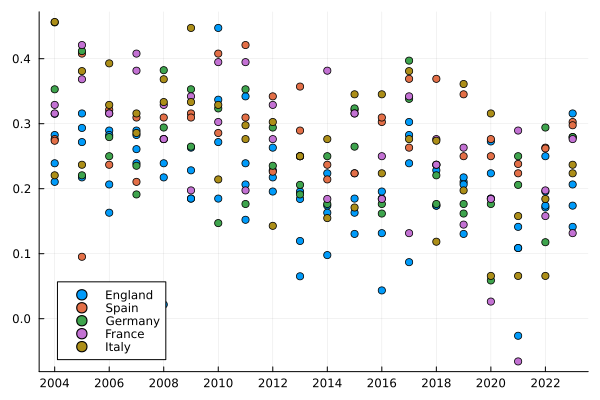

In [25]:
@df subset(masterTableSoccer,:Country => (c->c.=="England")) dotplot(:Year,:HFAdvPtsMedian,mode=:none, label="England")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain")) dotplot!(:Year,:HFAdvPtsMedian,mode=:none,label ="Spain")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany")) dotplot!(:Year,:HFAdvPtsMedian,mode=:none, label ="Germany")
@df subset(masterTableSoccer,:Country => (c->c.=="France")) dotplot!(:Year,:HFAdvPtsMedian,mode=:none, label ="France")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy")) dotplot!(:Year,:HFAdvPtsMedian,mode=:none, label ="Italy")
xticks!(2004:2:2023)

### Home field advantage median using points for top 5 european soccer leagues across the years

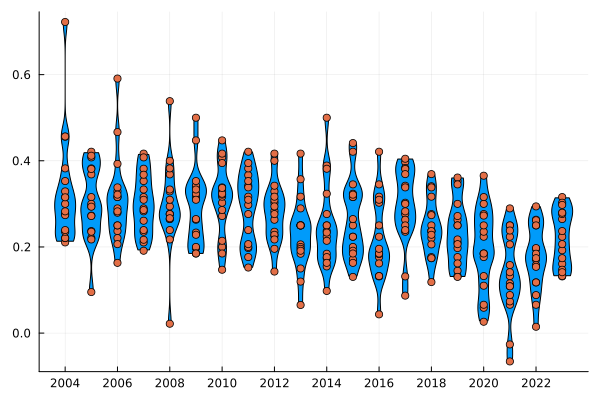

In [26]:
@df masterTableSoccer violin(:Year,:HFAdvPtsMedian,mode=:none, label="")
@df masterTableSoccer dotplot!(:Year,:HFAdvPtsMedian,mode=:none, label="")

xticks!(2004:2:2023)

In [27]:
masterTableSoccer;

## Creation of a table with all homefield advantage measures for soccer

In [28]:
masterTableSoccer.HFAdvGDMedian = medianLeagueHFAdvGD.(masterTableSoccer.LeagueTable);
masterTableSoccer.HFAdvPtsIqr = iqrLeagueHFAdvPts.(masterTableSoccer.LeagueTable);
masterTableSoccer.HFAdvGDiqr = iqrLeagueHFAdvGD.(masterTableSoccer.LeagueTable);
masterTableSoccer.HFAdvGFMedian = medianLeagueHFAdvGF.(masterTableSoccer.LeagueTable);
masterTableSoccer.HFAdvGFiqr = iqrLeagueHFAdvGF.(masterTableSoccer.LeagueTable);
masterTableSoccer.TSPtsMedian = medianLeagueTSPts.(masterTableSoccer.LeagueTable);
masterTableSoccer.TSPtsiqr = iqrLeagueTSPts.(masterTableSoccer.LeagueTable);
masterTableSoccer.TSGDMedian = medianLeagueTSGD.(masterTableSoccer.LeagueTable);
masterTableSoccer.TSGDiqr = iqrLeagueTSGD.(masterTableSoccer.LeagueTable);
masterTableSoccer; 

In [29]:
hfAdvTable = select(masterTableSoccer, :Country, :Division, :Year, :HFAdvPtsMedian,
    :HFAdvGDMedian,:HFAdvGFMedian,:HFAdvPtsIqr,:HFAdvGDiqr,:HFAdvGFiqr,:TSPtsMedian,
    :TSPtsiqr,:TSGDMedian,:TSGDiqr)

340×13 DataFrame
 Row │ Country      Division  Year   HFAdvPtsMedian  HFAdvGDMedian  HFAdvGFMed ⋯
     │ String       Int64     Int64  Float64         Float64        Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ England             1   2023        0.315789       0.394737      0.1447 ⋯
   2 │ France              1   2023        0.131579       0.184211      0.0789
   3 │ Germany             1   2023        0.279412       0.514706      0.2941
   4 │ Italy               1   2023        0.223684       0.263158      0.1184
   5 │ Spain               1   2023        0.302632       0.394737      0.2236 ⋯
   6 │ USA                 1   2023        0.160714       0.196429      0.125
   7 │ Belgium             1   2023        0.147059       0.205882      0.1176
   8 │ Netherlands         1   2023        0.132353       0.367647      0.1764
   9 │ Portugal            1   2023        0.264706       0.323529      0.1470 ⋯
  10 │ Greece              1   2023        0.192308       0.307692      0.1538
  11 │ England             2   2023        0.173913       0.25          0.0869
  ⋮  │      ⋮          ⋮        ⋮          ⋮               ⋮              ⋮    ⋱
 331 │ Netherlands         1   2004        0.235294       0.441176      0.2058
 332 │ Portugal            1   2004        0.382353       0.455882      0.1911 ⋯
 333 │ Greece              1   2004        0.3            0.433333      0.2166
 334 │ England             2   2004        0.23913        0.347826      0.1847
 335 │ France              2   2004        0.328947       0.447368      0.2763
 336 │ Germany             2   2004        0.352941       0.470588      0.2205 ⋯
 337 │ Italy               2   2004        0.456522       0.521739      0.2173
 338 │ Spain               2   2004        0.27381        0.309524      0.1547
 339 │ England             3   2004        0.315217       0.456522      0.3043
 340 │ England             4   2004        0.282609       0.391304      0.1847 ⋯
                                                  8 columns and 319 rows omitted

### Graphing of the different home fieled advantage metrics

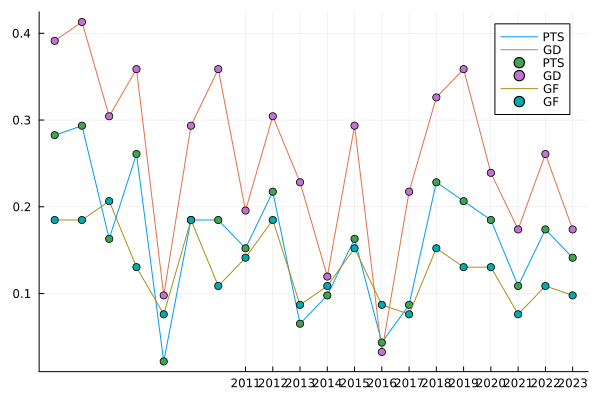

In [30]:
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==4)) plot(:Year,:HFAdvPtsMedian,mode=:none, label="PTS")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==4)) plot!(:Year,:HFAdvGDMedian,mode=:none, label="GD")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==4)) scatter!(:Year,:HFAdvPtsMedian,mode=:none, label="PTS")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==4)) scatter!(:Year,:HFAdvGDMedian,mode=:none, label="GD")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==4)) plot!(:Year,:HFAdvGFMedian,mode=:none, label="GF")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==4)) scatter!(:Year,:HFAdvGFMedian,mode=:none, label="GF")

xticks!(2011:2023)

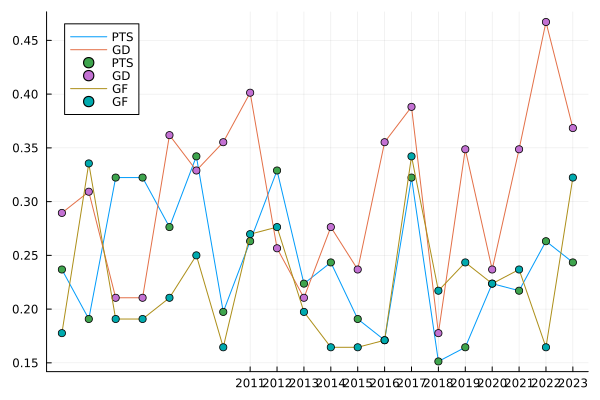

In [31]:
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==1)) plot(:Year,:HFAdvPtsIqr,mode=:none, label="PTS")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==1)) plot!(:Year,:HFAdvGDiqr,mode=:none, label="GD")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==1)) scatter!(:Year,:HFAdvPtsIqr,mode=:none, label="PTS")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==1)) scatter!(:Year,:HFAdvGDiqr,mode=:none, label="GD")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==1)) plot!(:Year,:HFAdvGFiqr,mode=:none, label="GF")
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==1)) scatter!(:Year,:HFAdvGFiqr,mode=:none, label="GF")

xticks!(2011:2023)

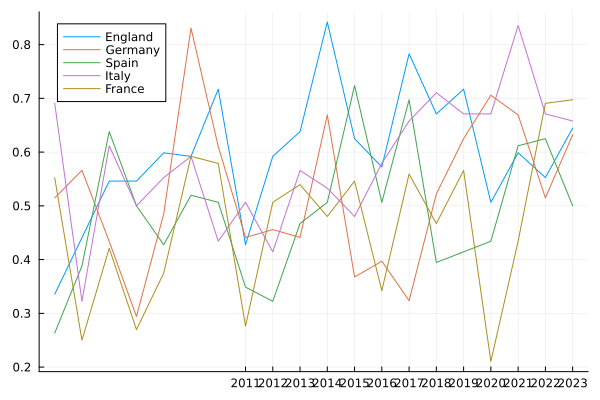

In [32]:
@df subset(hfAdvTable,:Country => (c->c.=="England"), :Division =>(d->d.==1)) plot(:Year,:TSPtsiqr,mode=:none, label="England")
@df subset(hfAdvTable,:Country => (c->c.=="Germany"), :Division =>(d->d.==1)) plot!(:Year,:TSPtsiqr,mode=:none, label="Germany")
@df subset(hfAdvTable,:Country => (c->c.=="Spain"), :Division =>(d->d.==1)) plot!(:Year,:TSPtsiqr,mode=:none, label="Spain")
@df subset(hfAdvTable,:Country => (c->c.=="Italy"), :Division =>(d->d.==1)) plot!(:Year,:TSPtsiqr,mode=:none, label="Italy")
@df subset(hfAdvTable,:Country => (c->c.=="France"), :Division =>(d->d.==1)) plot!(:Year,:TSPtsiqr,mode=:none, label="France")

xticks!(2011:2023)

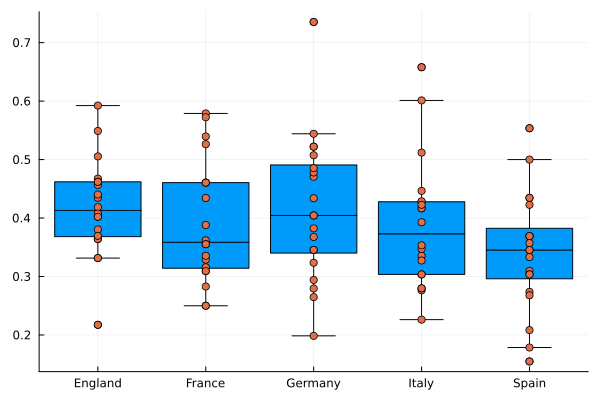

In [33]:
@df subset(hfAdvTable, :Division =>(d->d.==2)) boxplot(:Country,:TSPtsiqr,mode=:none,label="")
@df subset(hfAdvTable, :Division =>(d->d.==2)) dotplot!(:Country,:TSPtsiqr,mode=:none,label="")


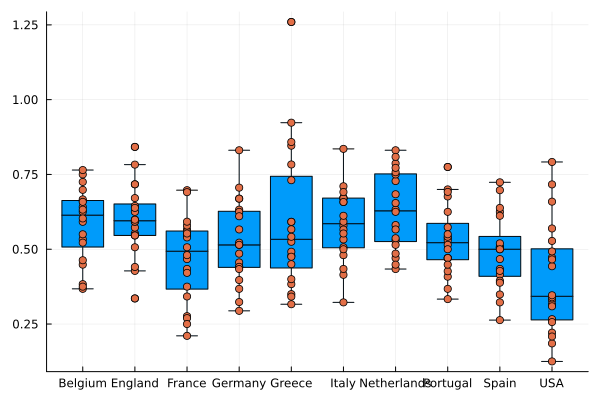

In [34]:
@df subset(hfAdvTable, :Division =>(d->d.==1)) boxplot(:Country,:TSPtsiqr,mode=:none,label="")
@df subset(hfAdvTable, :Division =>(d->d.==1)) dotplot!(:Country,:TSPtsiqr,mode=:none,label="")

# Home team win and competitiveness functions

## Home Team Win functions

In [35]:
function htwNFL(winner,loser,atsign)
    htw = ismissing(atsign) ? 1 : 0
    hometeam = (htw==1) ? winner : loser
    awayteam = (htw==0) ? winner : loser
    return (HTW=htw,HomeTeam=hometeam,AwayTeam=awayteam)
end

htwNFL (generic function with 1 method)

In [36]:
function htwNFL(df::DataFrame)
    df = transform(df,[:("Winner/tie"),:("Loser/tie"),:("Column6")] => 
        ((w,l,a)->htwNFL.(w,l,a)) => :nested)
    transform!(df,:nested=>AsTable)
    return df
end

htwNFL (generic function with 2 methods)

In [37]:
function hometeamwin(a)
    ismissing(a) ? "h" : "a"
end

hometeamwin (generic function with 1 method)

In [38]:
function htwSoccer(x::DataFrame)
    htw = transform!(x,[:FTHG,:FTAG] => ((hg,ag) -> (hg.>ag)) => :HTW)
    subset!(x,:FTHG=> (x->((!ismissing).(x))))
    htw = select(htw, :Date, :HomeTeam, :AwayTeam, :FTHG, :FTAG, :HTW)
    return htw
end

htwSoccer (generic function with 1 method)

In [39]:
function htdwSoccer(x::DataFrame)
    htdw = transform!(x,[:FTHG,:FTAG] => ((hg,ag) -> (hg.>=ag)) => :HTDW)
    subset!(x,:FTHG=> (x->((!ismissing).(x))))
    htdw = select(htdw, :Date, :HomeTeam, :AwayTeam, :FTHG, :FTAG, :HTDW)
    return htdw
end

htdwSoccer (generic function with 1 method)

In [40]:
htwSoccer.(masterTableSoccer.df);

In [41]:
function htwNBA(x::DataFrame)
    subset!(x,:PTS=> (x->((!ismissing).(x))))
    htw = zeros(size(x,1))
    for i in 1:size(x,1)
        if x[i,:PTS] > x[i,:PTS_1]
            htw[i] = 0
        else 
            htw[i] = 1
        end
    end
    x.HTW = htw
    return x
end

htwNBA (generic function with 1 method)

In [42]:
function htwNHL(x::DataFrame)
    subset!(x,:G=> (x->((!ismissing).(x))))
    htw = zeros(size(x,1))
    for i in 1:size(x,1)
        if x[i,:G] > x[i,:G_1]
            htw[i] = 0
        else 
            htw[i] = 1
        end
    end
    x.HTW = htw
    return x
end

htwNHL (generic function with 1 method)

In [43]:
function htwBasket(x::DataFrame)
    subset!(x,:PTS=> (x->((!ismissing).(x))))
    htw = zeros(size(x,1))
    for i in 1:size(x,1)
        if x[i,:PTS] > x[i,:PTS_1]
            htw[i] = 0
        else 
            htw[i] = 1
        end
    end
    x.HTW = htw
    return x
end

htwBasket (generic function with 1 method)

In [44]:
function htwMLB(x::DataFrame)
    subset!(x,:HomeTeamScore=> (x->((!ismissing).(x))))
    htw = zeros(size(x,1))
    for i in 1:size(x,1)
        if x[i,:HomeTeamScore] > x[i,:AwayTeamScore]
            htw[i] = 1
        else 
            htw[i] = 0
        end
    end
    x.HTW = htw
    return x
end

htwMLB (generic function with 1 method)

## Functions for calculating competiveness from mixed models

In [45]:
function compBasket(x::DataFrame)
    comp = fit(MixedModel,@formula(HTW~1+(1|fulldummy(Team))+(1|fulldummy(Opp)),),htwBasket(x),Bernoulli())
    vc = VarCorr(comp)
    return (vc.σρ.Team.σ[1] + vc.σρ.Opp.σ[1])/2, coef(comp)[1]
end

compBasket (generic function with 1 method)

In [46]:
function compSoccer(x::DataFrame)
    comp = fit(MixedModel,@formula(HTW~1+(1|fulldummy(HomeTeam))+(1|fulldummy(AwayTeam)),),htwSoccer(x),Bernoulli())
    vc = VarCorr(comp)
    return (vc.σρ.HomeTeam.σ[1] + vc.σρ.AwayTeam.σ[1])/2, coef(comp)[1]
end

compSoccer (generic function with 1 method)

In [47]:
function compSoccerWithDraw(x::DataFrame)
    outWin = fit(MixedModel,@formula(HTW~1+(1|fulldummy(HomeTeam))+(1|fulldummy(AwayTeam)),),htwSoccer(x),Bernoulli())
    # check below
    outLoss = fit(MixedModel,@formula(HTDW~1+(1|fulldummy(HomeTeam))+(1|fulldummy(AwayTeam)),),htdwSoccer(x),Bernoulli())
    vcWin = VarCorr(outWin)
    vcLoss = VarCorr(outLoss)
    comp = (vcWin.σρ.HomeTeam.σ[1] + vcWin.σρ.AwayTeam.σ[1]+
        vcLoss.σρ.HomeTeam.σ[1] + vcLoss.σρ.AwayTeam.σ[1])/4
    return comp, (coef(outWin)[1]+coef(outLoss)[1])/2
end

compSoccerWithDraw (generic function with 1 method)

In [48]:
function compNHL(x::DataFrame)
    comp = fit(MixedModel,@formula(HTW~1+(1|fulldummy(Home))+(1|fulldummy(Visitor)),),htwNHL(x),Bernoulli())
    vc = VarCorr(comp)
    return (vc.σρ.Home.σ[1] + vc.σρ.Visitor.σ[1])/2, coef(comp)[1]
end

compNHL (generic function with 1 method)

In [49]:
function compMLB(x::DataFrame)
    comp = fit(MixedModel,@formula(HTW~1+(1|fulldummy(HomeTeam))+(1|fulldummy(AwayTeam)),),htwMLB(x),Bernoulli())
    vc = VarCorr(comp)
    return (vc.σρ.HomeTeam.σ[1] + vc.σρ.AwayTeam.σ[1])/2, coef(comp)[1]
end

compMLB (generic function with 1 method)

In [50]:
function compNFL(x::DataFrame)
    comp = fit(MixedModel,@formula(HTW~1+(1|fulldummy(HomeTeam))+(1|fulldummy(AwayTeam)),),htwNFL(x),Bernoulli())
    vc = VarCorr(comp)
    return (vc.σρ.HomeTeam.σ[1] + vc.σρ.AwayTeam.σ[1])/2, coef(comp)[1]
end

compNFL (generic function with 1 method)

# Plots of competitiveness and home field advantage

In [51]:
masterTableSoccer = transform(masterTableSoccer,:df => (d->compSoccerWithDraw.(d))=>[:Comp,:HFA])

340×18 DataFrame
 Row │ Country      Division  Year   FileName                           df     ⋯
     │ String       Int64     Int64  String                             DataFr ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ England             1   2023  Data/Soccer/England/1/2023.csv     380×10 ⋯
   2 │ France              1   2023  Data/Soccer/France/1/2023.csv      380×10
   3 │ Germany             1   2023  Data/Soccer/Germany/1/2023.csv     306×10
   4 │ Italy               1   2023  Data/Soccer/Italy/1/2023.csv       380×10
   5 │ Spain               1   2023  Data/Soccer/Spain/1/2023.csv       380×10 ⋯
   6 │ USA                 1   2023  Data/Soccer/USA/1/2023.csv         279×21
   7 │ Belgium             1   2023  Data/Soccer/Belgium/1/2023.csv     306×10
   8 │ Netherlands         1   2023  Data/Soccer/Netherlands/1/2023.c…  306×10
   9 │ Portugal            1   2023  Data/Soccer/Portugal/1/2023.csv    306×10 ⋯
  10 │ Greece              1   2023  Data/Soccer/Greece/1/2023.csv      240×10
  11 │ England             2   2023  Data/Soccer/England/2/2023.csv     552×10
  ⋮  │      ⋮          ⋮        ⋮                    ⋮                         ⋱
 331 │ Netherlands         1   2004  Data/Soccer/Netherlands/1/2004.c…  306×54
 332 │ Portugal            1   2004  Data/Soccer/Portugal/1/2004.csv    306×52 ⋯
 333 │ Greece              1   2004  Data/Soccer/Greece/1/2004.csv      240×45
 334 │ England             2   2004  Data/Soccer/England/2/2004.csv     552×59
 335 │ France              2   2004  Data/Soccer/France/2/2004.csv      380×51
 336 │ Germany             2   2004  Data/Soccer/Germany/2/2004.csv     306×49 ⋯
 337 │ Italy               2   2004  Data/Soccer/Italy/2/2004.csv       552×55
 338 │ Spain               2   2004  Data/Soccer/Spain/2/2004.csv       462×45
 339 │ England             3   2004  Data/Soccer/England/3/2004.csv     552×57
 340 │ England             4   2004  Data/Soccer/England/4/2004.csv     552×56 ⋯
                                                 14 columns and 319 rows omitted

In [52]:
masterTableSoccer;

# Creation of basketball mastertable

In [53]:
league = ["CBA","GBL","Liga ACB","LNB","NBA","NBL"];
years = ["2023" "2022" "2021" "2020" "2019" "2018" "2017" "2016" "2015" "2014" "2013" "2012"];
filecalls = "Data/Basketball/".* league .* "/" .* years .* ".csv";
filecalls = vec(filecalls);
league = repeat(league, 12);
years23 = repeat([2023], 6)
years22 = repeat([2022], 6)
years21 = repeat([2021], 6)
years20 = repeat([2020], 6)
years19 = repeat([2019], 6)
years18 = repeat([2018], 6)
years17 = repeat([2017], 6)
years16 = repeat([2016], 6)
years15 = repeat([2015], 6)
years14 = repeat([2014], 6)
years13 = repeat([2013], 6)
years12 = repeat([2012], 6)
years = vcat(years23,years22,years21,years20,years19,years18,years17,years16,years15,years14,years13,years12);

In [54]:
fileListBasketball = DataFrame(League=league, Year=years, FileName=filecalls)

72×3 DataFrame
 Row │ League    Year   FileName                          
     │ String    Int64  String                            
─────┼────────────────────────────────────────────────────
   1 │ CBA        2023  Data/Basketball/CBA/2023.csv
   2 │ GBL        2023  Data/Basketball/GBL/2023.csv
   3 │ Liga ACB   2023  Data/Basketball/Liga ACB/2023.csv
   4 │ LNB        2023  Data/Basketball/LNB/2023.csv
   5 │ NBA        2023  Data/Basketball/NBA/2023.csv
   6 │ NBL        2023  Data/Basketball/NBL/2023.csv
   7 │ CBA        2022  Data/Basketball/CBA/2022.csv
   8 │ GBL        2022  Data/Basketball/GBL/2022.csv
   9 │ Liga ACB   2022  Data/Basketball/Liga ACB/2022.csv
  10 │ LNB        2022  Data/Basketball/LNB/2022.csv
  11 │ NBA        2022  Data/Basketball/NBA/2022.csv
  ⋮  │    ⋮        ⋮                    ⋮
  63 │ Liga ACB   2013  Data/Basketball/Liga ACB/2013.csv
  64 │ LNB        2013  Data/Basketball/LNB/2013.csv
  65 │ NBA        2013  Data/Basketball/NBA/2013.csv
  66 │ NBL        2013  Data/Basketball/NBL/2013.csv
  67 │ CBA        2012  Data/Basketball/CBA/2012.csv
  68 │ GBL        2012  Data/Basketball/GBL/2012.csv
  69 │ Liga ACB   2012  Data/Basketball/Liga ACB/2012.csv
  70 │ LNB        2012  Data/Basketball/LNB/2012.csv
  71 │ NBA        2012  Data/Basketball/NBA/2012.csv
  72 │ NBL        2012  Data/Basketball/NBL/2012.csv
                                           51 rows omitted

In [55]:
function readFileSkipMissingBasket(filename::String)
    if isnothing(match(r"/NBA/",filename))
        CSV.read(filename, DataFrame, ignoreemptyrows=true) |> (df->subset(df,:PTS => (z->(!ismissing).(z))))
    else
        frame = CSV.read(filename, DataFrame, ignoreemptyrows=true) |> (df->subset(df,:PTS => (z->(!ismissing).(z))))
        frame = rename(frame, Symbol("Visitor/Neutral") => :Opp, Symbol("Home/Neutral") => :Team)
    end
end

readFileSkipMissingBasket (generic function with 1 method)

In [56]:
masterTableBasketball = transform(fileListBasketball,:FileName => (files->readFileSkipMissingBasket.(files)) => :df);

In [57]:
masterTableBasketball = transform(masterTableBasketball,:df => (d->compBasket.(d))=>[:Comp,:HFA]);

In [58]:
masterTableBasketball

72×6 DataFrame
 Row │ League    Year   FileName                           df                  ⋯
     │ String    Int64  String                             DataFrame           ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CBA        2023  Data/Basketball/CBA/2023.csv       411×10 DataFrame    ⋯
   2 │ GBL        2023  Data/Basketball/GBL/2023.csv       132×10 DataFrame  
   3 │ Liga ACB   2023  Data/Basketball/Liga ACB/2023.csv  306×10 DataFrame  
   4 │ LNB        2023  Data/Basketball/LNB/2023.csv       306×10 DataFrame  
   5 │ NBA        2023  Data/Basketball/NBA/2023.csv       1230×12 DataFrame   ⋯
   6 │ NBL        2023  Data/Basketball/NBL/2023.csv       140×10 DataFrame  
   7 │ CBA        2022  Data/Basketball/CBA/2022.csv       380×10 DataFrame  
   8 │ GBL        2022  Data/Basketball/GBL/2022.csv       156×10 DataFrame  
   9 │ Liga ACB   2022  Data/Basketball/Liga ACB/2022.csv  306×10 DataFrame    ⋯
  10 │ LNB        2022  Data/Basketball/LNB/2022.csv       323×10 DataFrame  
  11 │ NBA        2022  Data/Basketball/NBA/2022.csv       1230×12 DataFrame 
  ⋮  │    ⋮        ⋮                    ⋮                          ⋮           ⋱
  63 │ Liga ACB   2013  Data/Basketball/Liga ACB/2013.csv  306×10 DataFrame  
  64 │ LNB        2013  Data/Basketball/LNB/2013.csv       240×10 DataFrame    ⋯
  65 │ NBA        2013  Data/Basketball/NBA/2013.csv       1229×12 DataFrame 
  66 │ NBL        2013  Data/Basketball/NBL/2013.csv       112×10 DataFrame  
  67 │ CBA        2012  Data/Basketball/CBA/2012.csv       272×10 DataFrame  
  68 │ GBL        2012  Data/Basketball/GBL/2012.csv       156×10 DataFrame    ⋯
  69 │ Liga ACB   2012  Data/Basketball/Liga ACB/2012.csv  306×10 DataFrame  
  70 │ LNB        2012  Data/Basketball/LNB/2012.csv       240×10 DataFrame  
  71 │ NBA        2012  Data/Basketball/NBA/2012.csv       990×12 DataFrame  
  72 │ NBL        2012  Data/Basketball/NBL/2012.csv       126×10 DataFrame    ⋯
                                                   2 columns and 51 rows omitted

# Plots of major sports leagues

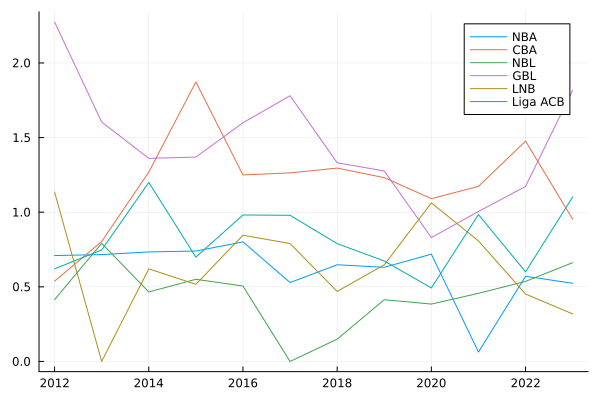

In [59]:
@df subset(masterTableBasketball,:League => (c->c.=="NBA")) plot(:Year,:Comp,mode=:none, label="NBA")
@df subset(masterTableBasketball,:League => (c->c.=="CBA")) plot!(:Year,:Comp,mode=:none, label="CBA")
@df subset(masterTableBasketball,:League => (c->c.=="NBL")) plot!(:Year,:Comp,mode=:none, label="NBL")
@df subset(masterTableBasketball,:League => (c->c.=="GBL")) plot!(:Year,:Comp,mode=:none, label="GBL")
@df subset(masterTableBasketball,:League => (c->c.=="LNB")) plot!(:Year,:Comp,mode=:none, label="LNB")
@df subset(masterTableBasketball,:League => (c->c.=="Liga ACB")) plot!(:Year,:Comp,mode=:none, label="Liga ACB")

xticks!(2004:2:2023)

## Creation of American sports league tables

In [70]:
yrs = [ "2022" "2021" "2020" "2019" "2018" "2017" "2016" "2015" "2014" "2013" "2012" "2011" "2010" "2009" "2008" "2007" "2006" "2005" "2004"]
filecallMLB = "Data/MLB/" .* yrs .* ".csv"
filecallMLB = vec(filecallMLB)
yrs = [2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004]
orgMLB = repeat(["MLB"],19)
masterTableMLB = DataFrame(League=orgMLB,Year=yrs,FileName=filecallMLB)
masterTableMLB = transform(masterTableMLB,:FileName => (files->readFileSkipMissing.(files)) => :df);
masterTableMLB = transform(masterTableMLB,:df => (d->compMLB.(d))=>[:Comp,:HFA])
masterTableMLB

19×6 DataFrame
 Row │ League  Year   FileName           df                  Comp      HFA     ⋯
     │ String  Int64  String             DataFrame           Float64   Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ MLB      2022  Data/MLB/2022.csv  2430×162 DataFrame  0.314236  0.13971 ⋯
   2 │ MLB      2021  Data/MLB/2021.csv  2429×162 DataFrame  0.308012  0.16474
   3 │ MLB      2020  Data/MLB/2020.csv  898×162 DataFrame   0.297617  0.23909
   4 │ MLB      2019  Data/MLB/2019.csv  2429×162 DataFrame  0.351319  0.12420
   5 │ MLB      2018  Data/MLB/2018.csv  2431×162 DataFrame  0.335308  0.11804 ⋯
   6 │ MLB      2017  Data/MLB/2017.csv  2430×162 DataFrame  0.192968  0.16315
   7 │ MLB      2016  Data/MLB/2016.csv  2428×162 DataFrame  0.191815  0.12284
   8 │ MLB      2015  Data/MLB/2015.csv  2429×162 DataFrame  0.201281  0.16944
   9 │ MLB      2014  Data/MLB/2014.csv  2430×162 DataFrame  0.181815  0.12240 ⋯
  10 │ MLB      2013  Data/MLB/2013.csv  2431×162 DataFrame  0.236834  0.15658
  11 │ MLB      2012  Data/MLB/2012.csv  2430×162 DataFrame  0.223062  0.13556
  12 │ MLB      2011  Data/MLB/2011.csv  2429×162 DataFrame  0.213412  0.10560
  13 │ MLB      2010  Data/MLB/2010.csv  2430×162 DataFrame  0.23207   0.24470 ⋯
  14 │ MLB      2009  Data/MLB/2009.csv  2430×162 DataFrame  0.234652  0.20033
  15 │ MLB      2008  Data/MLB/2008.csv  2428×162 DataFrame  0.211415  0.23119
  16 │ MLB      2007  Data/MLB/2007.csv  2431×162 DataFrame  0.129989  0.17059
  17 │ MLB      2006  Data/MLB/2006.csv  2429×162 DataFrame  0.167048  0.18975 ⋯
  18 │ MLB      2005  Data/MLB/2005.csv  2431×162 DataFrame  0.227036  0.15293
  19 │ MLB      2004  Data/MLB/2004.csv  2428×162 DataFrame  0.266634  0.14548
                                                                1 column omitted

In [71]:
yr = ["2023" "2022" "2021" "2020" "2019" "2018" "2017" "2016" "2015" "2014" "2013" "2012" "2011" "2010" "2009" "2008" "2007" "2006" "2005" "2004"]
filecallNFL = "Data/NFL/" .* yr .* ".csv"
filecallNFL = vec(filecallNFL)
yr = [2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004]
org = repeat(["NFL"],20)
masterTableNFL = DataFrame(League=org,Year=yr,FileName=filecallNFL)
masterTableNFL = transform(masterTableNFL,:FileName => (files->readFileSkipMissing.(files)) => :df);
masterTableNFL = transform(masterTableNFL,:df => (d->compNFL.(d))=>[:Comp,:HFA])
masterTableNFL

20×6 DataFrame
 Row │ League  Year   FileName           df                Comp      HFA       ⋯
     │ String  Int64  String             DataFrame         Float64   Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ NFL      2023  Data/NFL/2023.csv  271×14 DataFrame  0.47987   0.272243  ⋯
   2 │ NFL      2022  Data/NFL/2022.csv  272×14 DataFrame  0.512548  0.090773
   3 │ NFL      2021  Data/NFL/2021.csv  256×14 DataFrame  0.781605  0.0043204
   4 │ NFL      2020  Data/NFL/2020.csv  256×14 DataFrame  0.616227  0.0712337
   5 │ NFL      2019  Data/NFL/2019.csv  256×14 DataFrame  0.602379  0.460792  ⋯
   6 │ NFL      2018  Data/NFL/2018.csv  256×14 DataFrame  0.657847  0.323368
   7 │ NFL      2017  Data/NFL/2017.csv  256×14 DataFrame  0.755128  0.371047
   8 │ NFL      2016  Data/NFL/2016.csv  256×14 DataFrame  0.527259  0.176905
   9 │ NFL      2015  Data/NFL/2015.csv  256×14 DataFrame  0.701141  0.349332  ⋯
  10 │ NFL      2014  Data/NFL/2014.csv  256×14 DataFrame  0.667247  0.477919
  11 │ NFL      2013  Data/NFL/2013.csv  256×14 DataFrame  0.56656   0.347616
  12 │ NFL      2012  Data/NFL/2012.csv  256×14 DataFrame  0.781223  0.346526
  13 │ NFL      2011  Data/NFL/2011.csv  256×14 DataFrame  0.66469   0.285375  ⋯
  14 │ NFL      2010  Data/NFL/2010.csv  256×14 DataFrame  0.733531  0.3458
  15 │ NFL      2009  Data/NFL/2009.csv  256×14 DataFrame  0.731652  0.34474
  16 │ NFL      2008  Data/NFL/2008.csv  256×14 DataFrame  1.00239   0.403131
  17 │ NFL      2007  Data/NFL/2007.csv  256×14 DataFrame  0.439391  0.138857  ⋯
  18 │ NFL      2006  Data/NFL/2006.csv  256×14 DataFrame  0.932394  0.503181
  19 │ NFL      2005  Data/NFL/2005.csv  256×14 DataFrame  0.651389  0.322525
  20 │ NFL      2004  Data/NFL/2004.csv  256×14 DataFrame  0.844079  0.60906
                                                                1 column omitted

In [72]:
yr = ["2023" "2022" "2021" "2020" "2019" "2018" "2017" "2016" "2015" "2014" "2013" "2012" "2011" "2010" "2009" "2008" "2007" "2006" "2005" "2004"]
filecallNBA = "Data/Basketball/NBA/" .* yr .* ".csv"
filecallNBA = vec(filecallNBA)
yr = [2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004]
org = repeat(["NBA"],20)
masterTableNBA = DataFrame(League=org,Year=yr,FileName=filecallNBA)
masterTableNBA = transform(masterTableNBA,:FileName => (files->readFileSkipMissingBasket.(files)) => :df);
masterTableNBA = transform(masterTableNBA,:df => (d->compBasket.(d))=>[:Comp,:HFA])
masterTableNBA

20×6 DataFrame
 Row │ League  Year   FileName                      df                 Comp    ⋯
     │ String  Int64  String                        DataFrame          Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ NBA      2023  Data/Basketball/NBA/2023.csv  1230×12 DataFrame  0.52384 ⋯
   2 │ NBA      2022  Data/Basketball/NBA/2022.csv  1230×12 DataFrame  0.57024
   3 │ NBA      2021  Data/Basketball/NBA/2021.csv  1081×12 DataFrame  0.06288
   4 │ NBA      2020  Data/Basketball/NBA/2020.csv  1059×12 DataFrame  0.71873
   5 │ NBA      2019  Data/Basketball/NBA/2019.csv  1230×12 DataFrame  0.63069 ⋯
   6 │ NBA      2018  Data/Basketball/NBA/2018.csv  1230×12 DataFrame  0.64778
   7 │ NBA      2017  Data/Basketball/NBA/2017.csv  1230×12 DataFrame  0.52874
   8 │ NBA      2016  Data/Basketball/NBA/2016.csv  1230×12 DataFrame  0.80099
   9 │ NBA      2015  Data/Basketball/NBA/2015.csv  1230×12 DataFrame  0.73984 ⋯
  10 │ NBA      2014  Data/Basketball/NBA/2014.csv  1230×12 DataFrame  0.73356
  11 │ NBA      2013  Data/Basketball/NBA/2013.csv  1229×12 DataFrame  0.71593
  12 │ NBA      2012  Data/Basketball/NBA/2012.csv  990×12 DataFrame   0.70943
  13 │ NBA      2011  Data/Basketball/NBA/2011.csv  1230×12 DataFrame  0.77636 ⋯
  14 │ NBA      2010  Data/Basketball/NBA/2010.csv  1230×12 DataFrame  0.77985
  15 │ NBA      2009  Data/Basketball/NBA/2009.csv  1230×12 DataFrame  0.82837
  16 │ NBA      2008  Data/Basketball/NBA/2008.csv  1230×12 DataFrame  0.81640
  17 │ NBA      2007  Data/Basketball/NBA/2007.csv  1230×12 DataFrame  0.53301 ⋯
  18 │ NBA      2006  Data/Basketball/NBA/2006.csv  1230×12 DataFrame  0.56663
  19 │ NBA      2005  Data/Basketball/NBA/2005.csv  1230×12 DataFrame  0.72807
  20 │ NBA      2004  Data/Basketball/NBA/2004.csv  1189×12 DataFrame  0.60364
                                                               2 columns omitted

In [242]:
country = ["England","France","Germany","Italy","USA"];
years = ["2023" "2022" "2021" "2020" "2019" "2018" "2017" "2016" "2015" "2014" "2013"];
filecallWSoccer = "Data/WSoccer/".* country .* "/" .* years .* ".csv";
dontexist = ["Data/WSoccer/England/2013.csv","Data/WSoccer/England/2014.csv","Data/WSoccer/England/2015.csv","Data/WSoccer/England/2016.csv",
"Data/WSoccer/France/2013.csv","Data/WSoccer/France/2014.csv","Data/WSoccer/France/2015.csv","Data/WSoccer/France/2016.csv",
"Data/WSoccer/Germany/2013.csv","Data/WSoccer/Germany/2014.csv","Data/WSoccer/Germany/2015.csv","Data/WSoccer/Italy/2013.csv",
"Data/WSoccer/Italy/2014.csv","Data/WSoccer/Italy/2015.csv","Data/WSoccer/Italy/2016.csv","Data/WSoccer/Italy/2017.csv","Data/WSoccer/USA/2020.csv",
"Data/WSoccer/England/2023.csv","Data/WSoccer/France/2023.csv","Data/WSoccer/Germany/2023.csv","Data/WSoccer/Italy/2023.csv",]
filecallWSoccer = filter(x -> !(x in dontexist), filecallWSoccer)
filecallWSoccer = vec(filecallWSoccer)
Countries = ["USA","England","France","Germany","Italy","USA","England","France","Germany","Italy","USA","England","France","Germany","Italy","England","France","Germany","Italy","USA",
"England","France","Germany","Italy","USA","England","France","Germany","USA","Germany", "USA","USA","USA","USA"]
years23 = repeat([2023], 1)
years22 = repeat([2022], 5)
years21 = repeat([2021], 5)
years20 = repeat([2020], 4)
years19 = repeat([2019], 5)
years18 = repeat([2018], 5)
years17 = repeat([2017], 4)
years16 = repeat([2016], 2)
years15 = repeat([2015], 1)
years14 = repeat([2014], 1)
years13 = repeat([2013], 1)
years = vcat(years23,years22,years21,years20,years19,years18,years17,years16,years15,years14,years13);
WSoccerfileList = DataFrame(Country=Countries, Year=years, FileName=filecallWSoccer);
first(fileList,20)
masterTableWSoccer = transform(WSoccerfileList,:FileName => (files->readFileSkipMissingWSoccer.(files)) => :df)
masterTableWSoccer = transform(masterTableWSoccer,:df => (d->compSoccer.(d))=>[:Comp,:HFA])

34×6 DataFrame
 Row │ Country  Year   FileName                       df                Comp   ⋯
     │ String   Int64  String                         DataFrame         Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ USA       2023  Data/WSoccer/USA/2023.csv      90×17 DataFrame   0.0    ⋯
   2 │ England   2022  Data/WSoccer/England/2022.csv  132×17 DataFrame  1.6437
   3 │ France    2022  Data/WSoccer/France/2022.csv   132×17 DataFrame  1.4009
   4 │ Germany   2022  Data/WSoccer/Germany/2022.csv  132×17 DataFrame  1.6565
   5 │ Italy     2022  Data/WSoccer/Italy/2022.csv    90×17 DataFrame   1.1343 ⋯
   6 │ USA       2022  Data/WSoccer/USA/2022.csv      132×16 DataFrame  0.2676
   7 │ England   2021  Data/WSoccer/England/2021.csv  132×17 DataFrame  1.4555
   8 │ France    2021  Data/WSoccer/France/2021.csv   132×17 DataFrame  2.0800
   9 │ Germany   2021  Data/WSoccer/Germany/2021.csv  132×15 DataFrame  1.6280 ⋯
  10 │ Italy     2021  Data/WSoccer/Italy/2021.csv    132×17 DataFrame  1.3131
  11 │ USA       2021  Data/WSoccer/USA/2021.csv      120×16 DataFrame  0.3430
  ⋮  │    ⋮       ⋮                  ⋮                       ⋮             ⋮   ⋱
  25 │ USA       2018  Data/WSoccer/USA/2018.csv      108×14 DataFrame  0.9784
  26 │ England   2017  Data/WSoccer/England/2017.csv  90×14 DataFrame   1.5869 ⋯
  27 │ France    2017  Data/WSoccer/France/2017.csv   132×15 DataFrame  1.3215
  28 │ Germany   2017  Data/WSoccer/Germany/2017.csv  132×15 DataFrame  1.1846
  29 │ USA       2017  Data/WSoccer/USA/2017.csv      120×14 DataFrame  0.2973
  30 │ Germany   2016  Data/WSoccer/Germany/2016.csv  132×15 DataFrame  1.3383 ⋯
  31 │ USA       2016  Data/WSoccer/USA/2016.csv      100×14 DataFrame  0.6017
  32 │ USA       2015  Data/WSoccer/USA/2015.csv      90×14 DataFrame   0.1640
  33 │ USA       2014  Data/WSoccer/USA/2014.csv      108×14 DataFrame  0.3700
  34 │ USA       2013  Data/WSoccer/USA/2013.csv      88×14 DataFrame   0.3295 ⋯
                                                   2 columns and 13 rows omitted

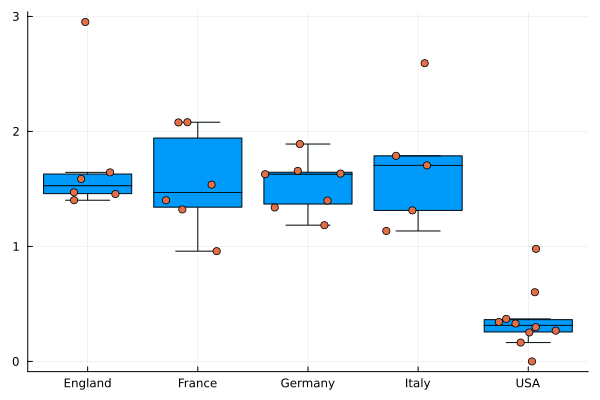

In [247]:
@df masterTableWSoccer boxplot(:Country,(:Comp),mode=:none, outliers=false,label="")
@df masterTableWSoccer dotplot!(:Country,(:Comp),mode=:density, label="")

In [302]:
usaMensSoccer = select( subset(masterTableSoccer, :Country =>(d->d.=="USA")), :Country .=> (x->"USA-M") => :Country, :Comp );
usaWomensSoccer = select( subset(masterTableWSoccer, :Country =>(d->d.=="USA")), :Country .=> (x->"USA-F") => :Country , :Comp );

In [300]:
usaSoccer = vcat(usaMensSoccer,usaWomensSoccer);

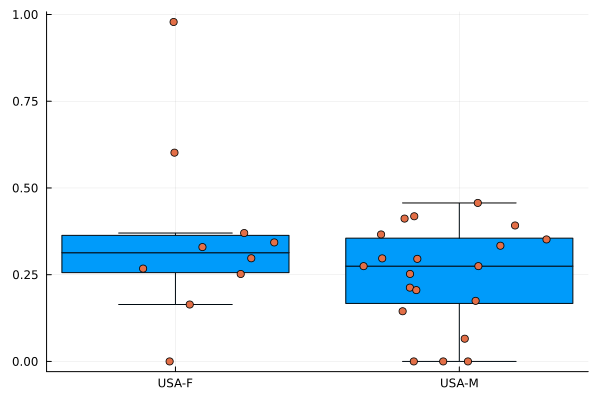

In [301]:
@df usaSoccer boxplot(:Country,:Comp,label="",outliers=false)
@df usaSoccer dotplot!(:Country,:Comp,mode=:density,label="")

In [293]:
usaWomens

10×2 DataFrame
 Row │ Country  Comp     
     │ String   Float64  
─────┼───────────────────
   1 │ USA-F    0.0
   2 │ USA-F    0.267619
   3 │ USA-F    0.343024
   4 │ USA-F    0.252015
   5 │ USA-F    0.978452
   6 │ USA-F    0.297322
   7 │ USA-F    0.601779
   8 │ USA-F    0.164048
   9 │ USA-F    0.370062
  10 │ USA-F    0.32959

## Plots of top 5 american leagues

### top 5 American leagues competitivness (2004-2023)

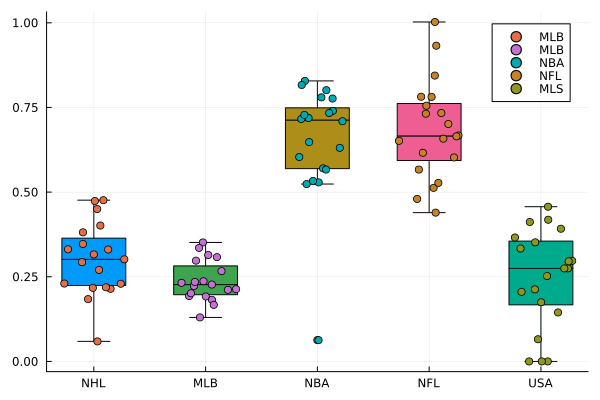

In [84]:
@df masterTableNHL boxplot(:League,:Comp,mode=:none,label="")
@df masterTableNHL dotplot!(:League,:Comp,mode=:density,label="MLB")
@df masterTableMLB boxplot!(:League,:Comp,mode=:none,label="")
@df masterTableMLB dotplot!(:League,:Comp,mode=:density,label="MLB")
@df masterTableNBA boxplot!(:League,:Comp,mode=:none, label="")
@df masterTableNBA dotplot!(:League,:Comp,mode=:density, label="NBA")
@df masterTableNFL boxplot!(:League,:Comp,mode=:none,label="")
@df masterTableNFL dotplot!(:League,:Comp,side=:both,mode=:density,label="NFL")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) boxplot!(:Country,:Comp,mode=:none,label="")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) dotplot!(:Country,:Comp,mode=:density,label="MLS")

As you can see here based on our compettivness metric the NFL and NBA are much less competitive than the MLS NHL and MLB. This may be due to a variety of reasons including the nature of each sport and the number of games in each league. Another possible reason could be the amount of player movement in each league and how easy it is to construct a dominant team or if every team is on an even playing field.

### top 5 american leagues competitivness taking into account their playoff structure

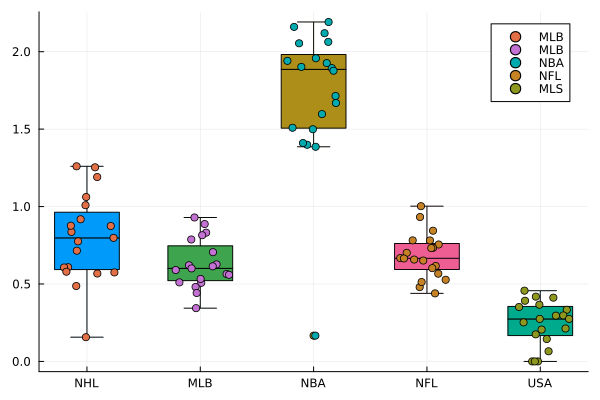

In [85]:
@df masterTableNHL boxplot(:League,:Comp*sqrt(7),mode=:none,label="")
@df masterTableNHL dotplot!(:League,:Comp*sqrt(7),mode=:density,label="MLB")
@df masterTableMLB boxplot!(:League,:Comp*sqrt(7),mode=:none,label="")
@df masterTableMLB dotplot!(:League,:Comp*sqrt(7),mode=:density,label="MLB")
@df masterTableNBA boxplot!(:League,:Comp*sqrt(7),mode=:none, label="")
@df masterTableNBA dotplot!(:League,:Comp*sqrt(7),mode=:density, label="NBA")
@df masterTableNFL boxplot!(:League,:Comp,mode=:none,label="")
@df masterTableNFL dotplot!(:League,:Comp,side=:both,mode=:density,label="NFL")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) boxplot!(:Country,:Comp,mode=:none,label="")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) dotplot!(:Country,:Comp,mode=:density,label="MLS")

Due to the MLS and NFLs single elimination playoffs they are significantly more competitive when taking into account their playoff structure. As you can see the NBA is the clear outlier in competitivness and you can argue that the best team is most likely to win the playoffs with less unpredictablity than the other sports.

### Home field advantage of the top 5 American sports leagues

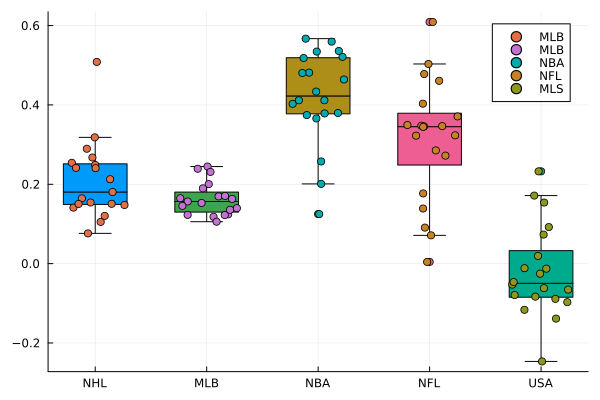

In [86]:
@df masterTableNHL boxplot(:League,:HFA,mode=:none,outliers=false,label="")
@df masterTableNHL dotplot!(:League,:HFA,mode=:density,label="MLB")
@df masterTableMLB boxplot!(:League,:HFA,mode=:none,label="")
@df masterTableMLB dotplot!(:League,:HFA,mode=:density,label="MLB")
@df masterTableNBA boxplot!(:League,:HFA,mode=:none, label="")
@df masterTableNBA dotplot!(:League,:HFA,mode=:density, label="NBA")
@df masterTableNFL boxplot!(:League,:HFA,mode=:none,label="")
@df masterTableNFL dotplot!(:League,:HFA,side=:both,mode=:density,label="NFL")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) boxplot!(:Country,:HFA,mode=:none,label="")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) dotplot!(:Country,:HFA,mode=:density,label="MLS")

A few factors to consider in this result shown above is the impact of a home field, the impact of fans and how many there are, and the level of influence a refree has on a game. Baseball is known to not have many fans at a lot of games and the nature of the sport leads to having a home field advantage difficult as there are so many games it tends to even out. With Soccer and Basketball, refs can have a huge impact on both games and fans hurl abuse at these refs the most in the NFL, NBA, and MLS likely leading to them being most biased in these sports. 

## Plot of competitiveness and home field advantage across leagues around the world

### Competitiveness of top 5 european soccer leagues

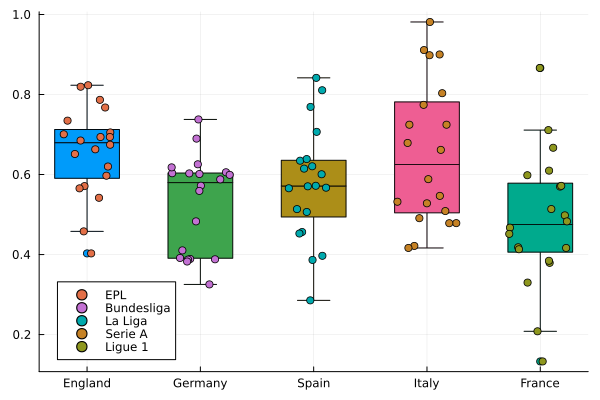

In [87]:
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==1)) boxplot(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="EPL")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==1)) boxplot!(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="Bundesliga")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==1)) boxplot!(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="La Liga")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==1)) boxplot!(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="Serie A")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==1)) boxplot!(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="Ligue 1")


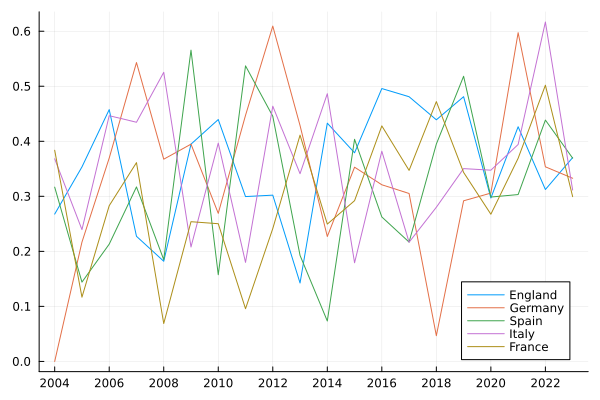

In [88]:
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==2)) plot(:Year,:Comp,mode=:none, label="England")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==2)) plot!(:Year,:Comp,mode=:none, label="Germany")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==2)) plot!(:Year,:Comp,mode=:none, label="Spain")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==2)) plot!(:Year,:Comp,mode=:none, label="Italy")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==2)) plot!(:Year,:Comp,mode=:none, label="France")

xticks!(2004:2:2023)

### Top 5 European soccer leagues and MLS competitivness

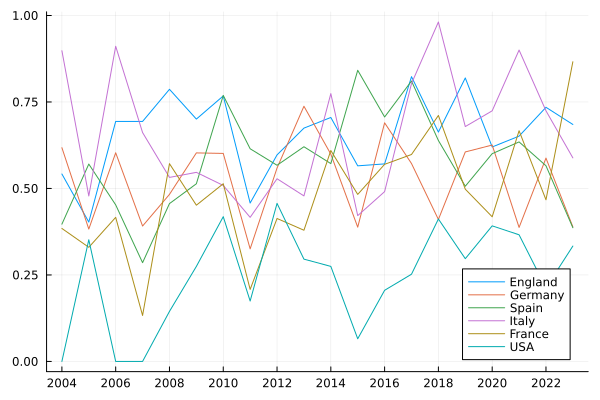

In [89]:
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==1)) plot(:Year,:Comp,mode=:none, label="England")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==1)) plot!(:Year,:Comp,mode=:none, label="Germany")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==1)) plot!(:Year,:Comp,mode=:none, label="Spain")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==1)) plot!(:Year,:Comp,mode=:none, label="Italy")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==1)) plot!(:Year,:Comp,mode=:none, label="France")
@df subset(masterTableSoccer,:Country => (c->c.=="USA"), :Division =>(d->d.==1)) plot!(:Year,:Comp,mode=:none, label="USA")

xticks!(2004:2:2023)

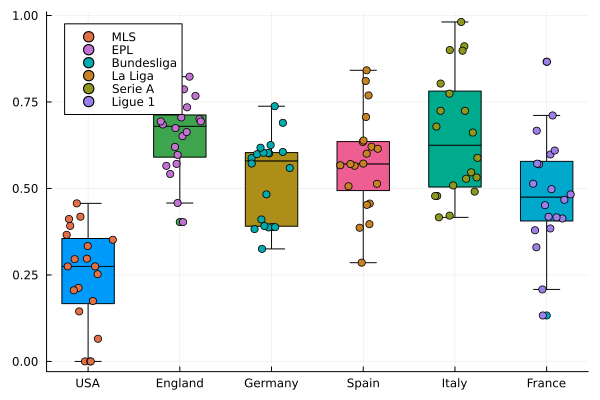

In [90]:
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) boxplot(:Country,:Comp,mode=:none,label="")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) dotplot!(:Country,:Comp,mode=:density,label="MLS")
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==1)) boxplot!(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="EPL")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==1)) boxplot!(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="Bundesliga")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==1)) boxplot!(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="La Liga")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==1)) boxplot!(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="Serie A")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==1)) boxplot!(:Country,:Comp,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density, label="Ligue 1")


It is clear that the MLS is the most competitive league that we have analyzed and this may be due to a few things. Firstly, the MLS does not have the same huge teams and is not a top tier league like these other ones which have historically huge clubs that stay near the top in almost all the leagues. Additionally, the MLS has a draft and salary cap which help even out the league and make the playing field more equal as opposed to the more capitalistic European system where the richest clubs dominate and it is nearly impossible for smaller, poorer clubs to find consistent success. 

### Home field advantage of the top 5 european leagues and MLS

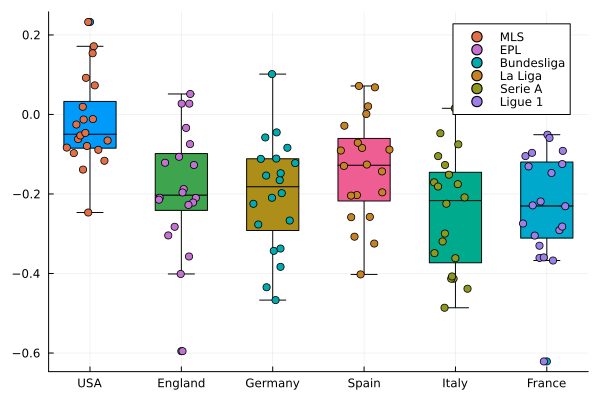

In [91]:
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) boxplot(:Country,:HFA,mode=:none,label="")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) dotplot!(:Country,:HFA,mode=:density,label="MLS")
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==1)) boxplot!(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==1)) dotplot!(:Country,:HFA,mode=:density, label="EPL")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==1)) boxplot!(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==1)) dotplot!(:Country,:HFA,mode=:density, label="Bundesliga")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==1)) boxplot!(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==1)) dotplot!(:Country,:HFA,mode=:density, label="La Liga")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==1)) boxplot!(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==1)) dotplot!(:Country,:HFA,mode=:density, label="Serie A")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==1)) boxplot!(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==1)) dotplot!(:Country,:HFA,mode=:density, label="Ligue 1")


### Competitiveness of 2nd division of the top 5 soccer leagues in europe and the MLS

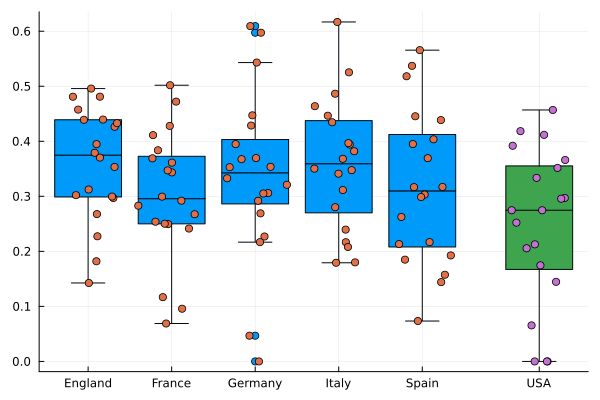

In [92]:
@df subset(masterTableSoccer, :Division =>(d->d.==2)) boxplot(:Country,:Comp,mode=:none,label="")
@df subset(masterTableSoccer, :Division =>(d->d.==2)) dotplot!(:Country,:Comp,mode=:density,label="")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) boxplot!(:Country,:Comp,mode=:none,label="")
@df subset(masterTableSoccer, :Country =>(d->d.=="USA")) dotplot!(:Country,:Comp,mode=:density,label="")

While the difference in competitivness isnt as defined when compared to the top flights the US is still slightly more compeitive when compared to leagues that could be argued are below its tier in level. This is likely due to the salary cap and draft systems implemented. The reason that these lower leagues are so similar to the MLS is that their budgets arent all that different accross the league as opposed to the top flights and the teams are on a much more even playing field financially.

### Second divisions of the top 5 European Home Field Advantage

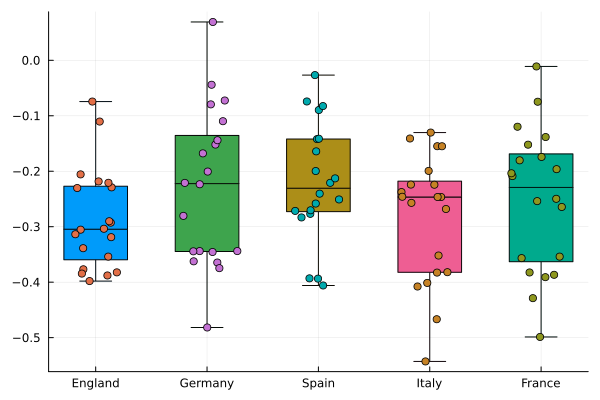

In [93]:
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==2)) boxplot(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==2)) dotplot!(:Country,:HFA,mode=:density, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==2)) boxplot!(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==2)) dotplot!(:Country,:HFA,mode=:density, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==2)) boxplot!(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==2)) dotplot!(:Country,:HFA,mode=:density, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==2)) boxplot!(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==2)) dotplot!(:Country,:HFA,mode=:density, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==2)) boxplot!(:Country,:HFA,mode=:none, label="")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==2)) dotplot!(:Country,:HFA,mode=:density, label="")

### Home field advantage and competitivness of all English Soccer Divisions

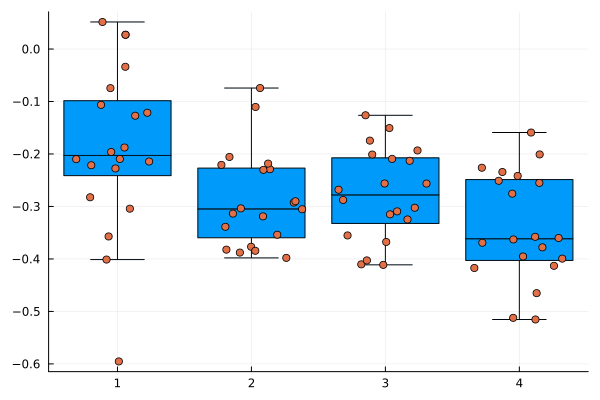

In [94]:
@df subset(masterTableSoccer,:Country => (c->c.=="England")) boxplot(:Division,:HFA,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="England")) dotplot!(:Division,:HFA,mode=:density, label="")

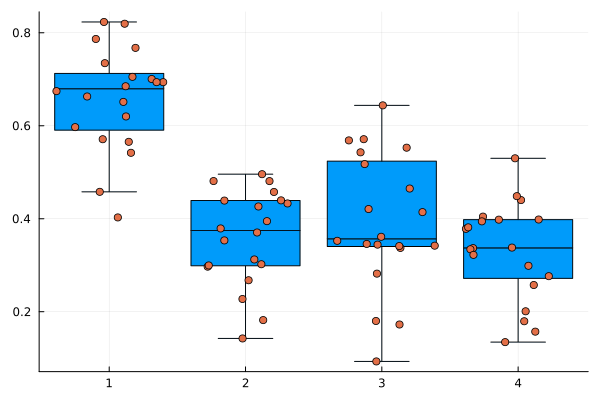

In [95]:
@df subset(masterTableSoccer,:Country => (c->c.=="England")) boxplot(:Division,:Comp,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="England")) dotplot!(:Division,:Comp,mode=:density, label="")

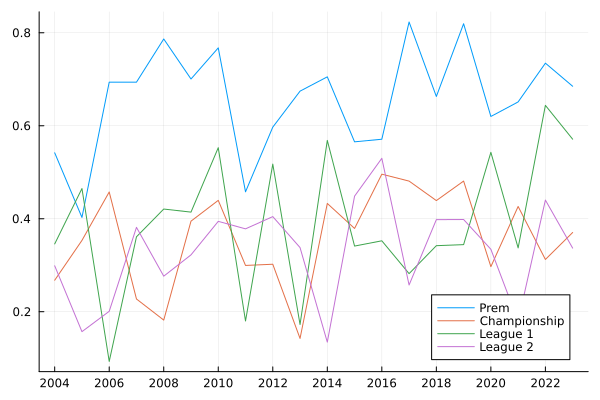

In [96]:
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==1)) plot(:Year,:Comp,mode=:none, label="Prem")
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==2)) plot!(:Year,:Comp,mode=:none, label="Championship")
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==3)) plot!(:Year,:Comp,mode=:none, label="League 1")
@df subset(masterTableSoccer,:Country => (c->c.=="England"), :Division =>(d->d.==4)) plot!(:Year,:Comp,mode=:none, label="League 2")

xticks!(2004:2:2023)

### Home field advantage and competitivness of all German Soccer Divisions

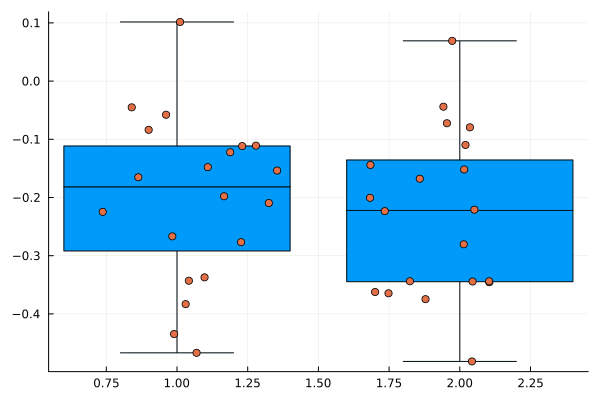

In [97]:
@df subset(masterTableSoccer,:Country => (c->c.=="Germany")) boxplot(:Division,:HFA,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany")) dotplot!(:Division,:HFA,mode=:density, label="")

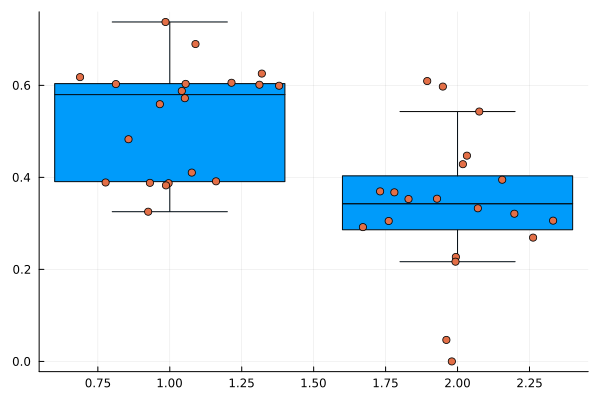

In [98]:
@df subset(masterTableSoccer,:Country => (c->c.=="Germany")) boxplot(:Division,:Comp,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany")) dotplot!(:Division,:Comp,mode=:density, label="")

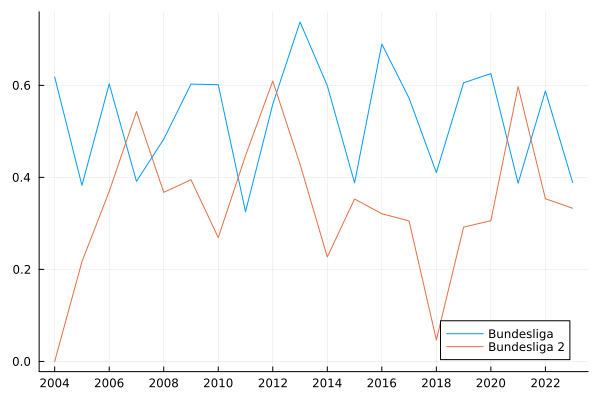

In [99]:
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==1)) plot(:Year,:Comp,mode=:none, label="Bundesliga")
@df subset(masterTableSoccer,:Country => (c->c.=="Germany"), :Division =>(d->d.==2)) plot!(:Year,:Comp,mode=:none, label="Bundesliga 2")

xticks!(2004:2:2023)

### Home field advantage and competitivness of all Spanish Soccer Divisions

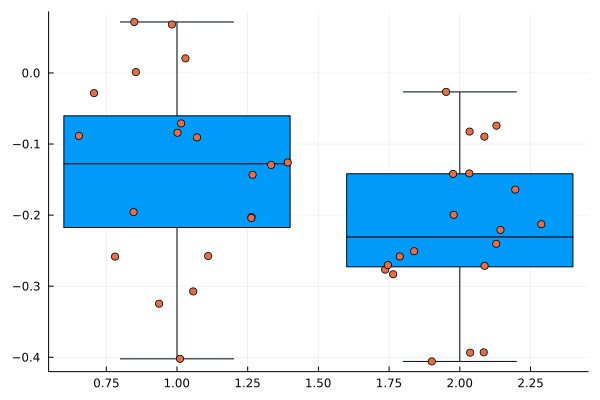

In [100]:
@df subset(masterTableSoccer,:Country => (c->c.=="Spain")) boxplot(:Division,:HFA,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain")) dotplot!(:Division,:HFA,mode=:density, label="")

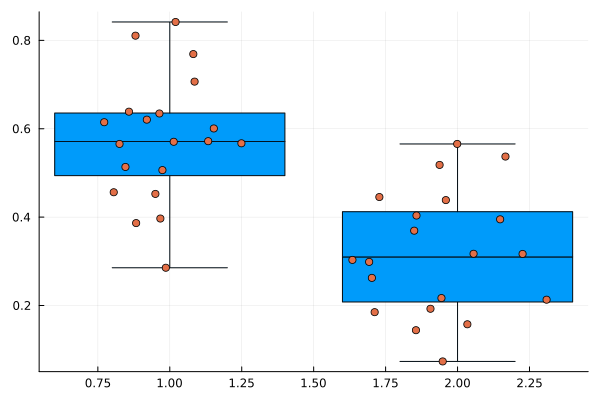

In [101]:
@df subset(masterTableSoccer,:Country => (c->c.=="Spain")) boxplot(:Division,:Comp,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain")) dotplot!(:Division,:Comp,mode=:density, label="")

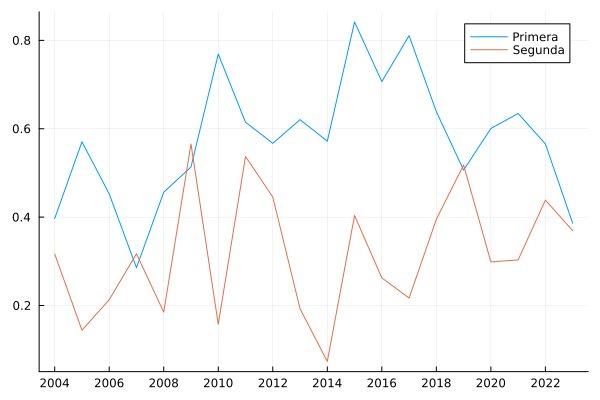

In [102]:
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==1)) plot(:Year,:Comp,mode=:none, label="Primera")
@df subset(masterTableSoccer,:Country => (c->c.=="Spain"), :Division =>(d->d.==2)) plot!(:Year,:Comp,mode=:none, label="Segunda")

xticks!(2004:2:2023)

### Home field advantage and competitivness of all Italian Soccer Divisions

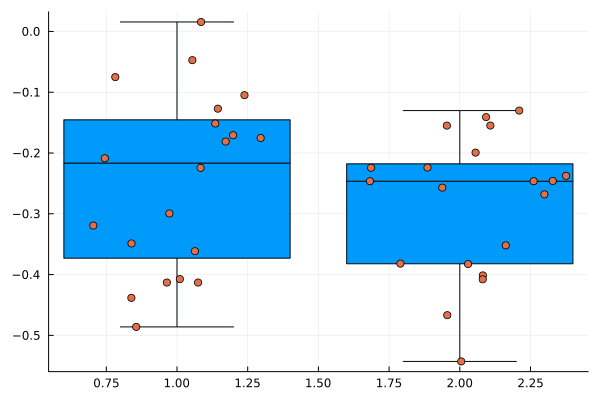

In [103]:
@df subset(masterTableSoccer,:Country => (c->c.=="Italy")) boxplot(:Division,:HFA,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy")) dotplot!(:Division,:HFA,mode=:density, label="")

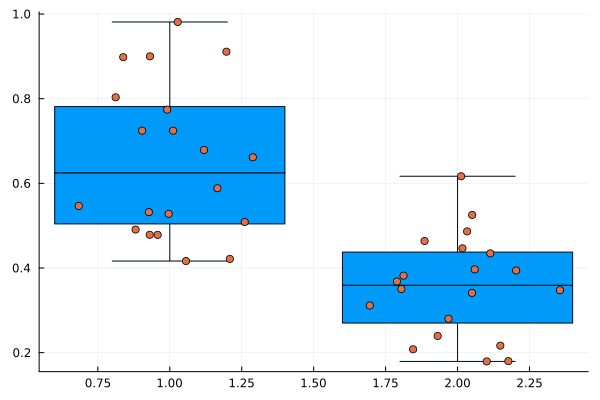

In [104]:
@df subset(masterTableSoccer,:Country => (c->c.=="Italy")) boxplot(:Division,:Comp,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy")) dotplot!(:Division,:Comp,mode=:density, label="")

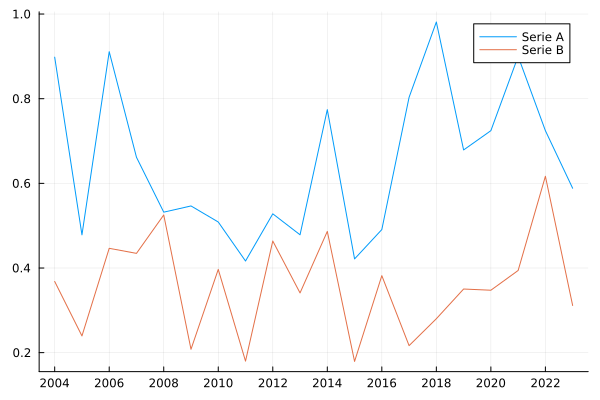

In [105]:
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==1)) plot(:Year,:Comp,mode=:none, label="Serie A")
@df subset(masterTableSoccer,:Country => (c->c.=="Italy"), :Division =>(d->d.==2)) plot!(:Year,:Comp,mode=:none, label="Serie B")

xticks!(2004:2:2023)

### Home field advantage and competitivness of all French Soccer Divisions

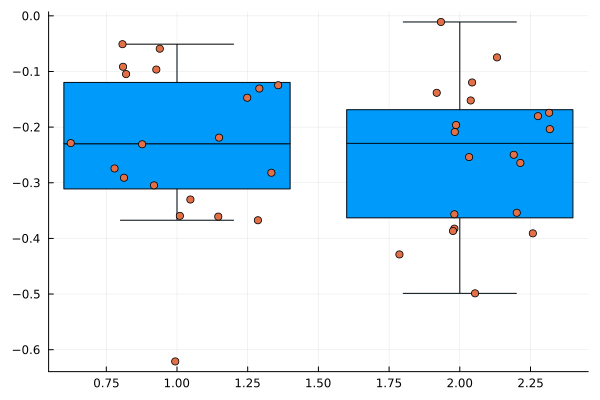

In [106]:
@df subset(masterTableSoccer,:Country => (c->c.=="France")) boxplot(:Division,:HFA,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="France")) dotplot!(:Division,:HFA,mode=:density, label="")

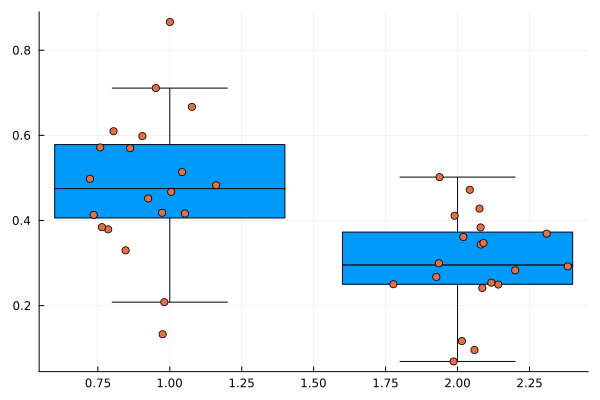

In [107]:
@df subset(masterTableSoccer,:Country => (c->c.=="France")) boxplot(:Division,:Comp,mode=:none, outliers=false,label="")
@df subset(masterTableSoccer,:Country => (c->c.=="France")) dotplot!(:Division,:Comp,mode=:density, label="")

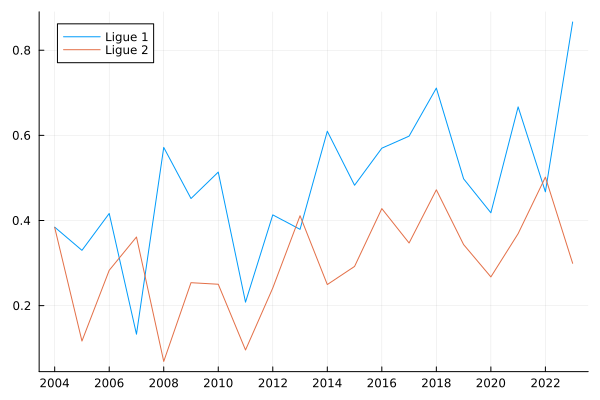

In [108]:
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==1)) plot(:Year,:Comp,mode=:none, label="Ligue 1")
@df subset(masterTableSoccer,:Country => (c->c.=="France"), :Division =>(d->d.==2)) plot!(:Year,:Comp,mode=:none, label="Ligue 2")

xticks!(2004:2:2023)

The general conclusion we can see here when comparing the tiers of different soccer leagues in Europe is that the lower divisions are more competitive than the higher divisions but the home field advantage is larely the same except in England. This may be due to the sheer difference in the number of fans for top English clubs and the level of scrutiny English refs are put under week in week out likely leading to them to be more biased in favor of the home team in order to appease the crowd and media.

### Distribution of HFA vs Comp of all leagues

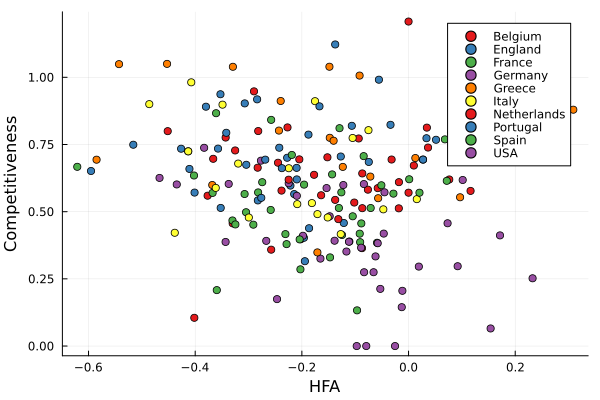

In [109]:
@df subset(masterTableSoccer,:Division =>(d->d.==1)) scatter(:HFA,:Comp,group=:Country,
           xlabel="HFA",ylabel="Competitiveness",palette=:Set1_6)

As you can see no clear correlation between teh HFA and competitivness in general but it is clear that the MLS is an outlier with its high competitivness and high home field advantage as well.

### Competitiveness of 6 top basketball leagues across the world

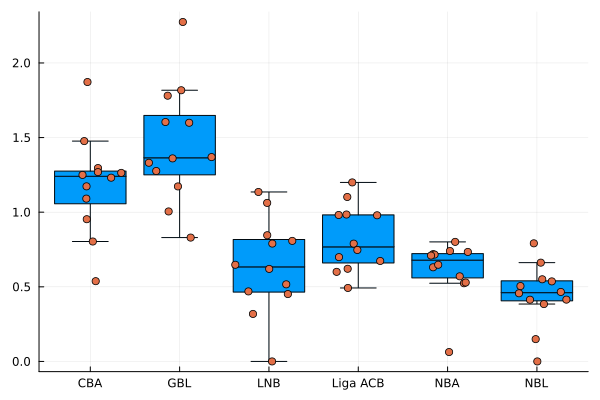

In [243]:
@df masterTableBasketball boxplot(:League,(:Comp),mode=:none, outliers=false,label="")
@df masterTableBasketball dotplot!(:League,(:Comp),mode=:density, label="")

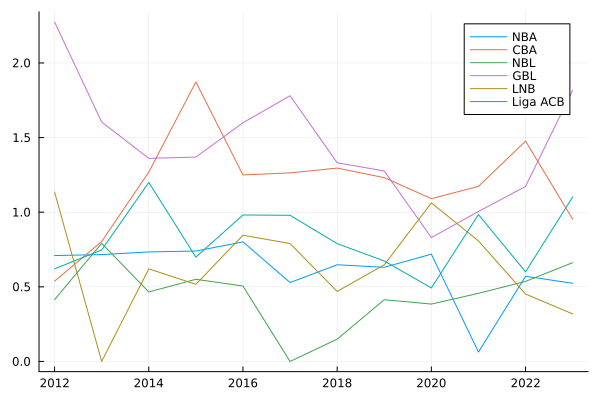

In [111]:
@df subset(masterTableBasketball,:League => (c->c.=="NBA")) plot(:Year,:Comp,mode=:none, label="NBA")
@df subset(masterTableBasketball,:League => (c->c.=="CBA")) plot!(:Year,:Comp,mode=:none, label="CBA")
@df subset(masterTableBasketball,:League => (c->c.=="NBL")) plot!(:Year,:Comp,mode=:none, label="NBL")
@df subset(masterTableBasketball,:League => (c->c.=="GBL")) plot!(:Year,:Comp,mode=:none, label="GBL")
@df subset(masterTableBasketball,:League => (c->c.=="LNB")) plot!(:Year,:Comp,mode=:none, label="LNB")
@df subset(masterTableBasketball,:League => (c->c.=="Liga ACB")) plot!(:Year,:Comp,mode=:none, label="Liga ACB")

xticks!(2004:2:2023)

A conclusion that is important to make is that the basketball leagues with salary caps are much more competitive than those without with the NBL and NBA leading the way. A great way to test this theory will be keeping an eye on the LNB in the coming seasons as they intend to enact a salary cap in their league.

In [112]:
subset(masterTableBasketball,:Comp =>(d->d.<.01))

2×6 DataFrame
 Row │ League  Year   FileName                      df                Comp     ⋯
     │ String  Int64  String                        DataFrame         Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ NBL      2017  Data/Basketball/NBL/2017.csv  112×10 DataFrame      0.0  ⋯
   2 │ LNB      2013  Data/Basketball/LNB/2013.csv  240×10 DataFrame      0.0
                                                                1 column omitted

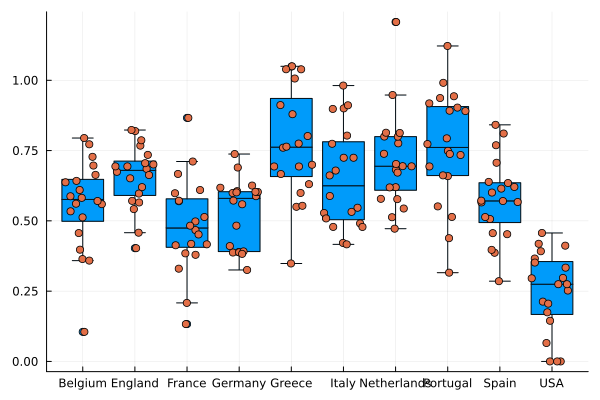

In [113]:
@df subset(masterTableSoccer, :Division =>(d->d.==1)) boxplot(:Country,:Comp,mode=:none,label="")
@df subset(masterTableSoccer, :Division =>(d->d.==1)) dotplot!(:Country,:Comp,mode=:density,label="")